Import neccessary packages

In [ ]:
%pip install numpy
%pip install opencv-python==4.6.0.66
%pip install sklearn
%pip install keras
%pip install matplotlib

In [3]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
EPOCHS = 45
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((100,100))
image_size = 0
directory_root ="C:\\Users\\Chaitali\\Downloads\\finalproject\\finalproject\\data"
width=100
height=100
depth=3

In [8]:
%pip install split-folders
import splitfolders # or import splitfolders
input_folder ="C:\\Users\\Chaitali\\Downloads\\finalproject\\finalproject\\data"
output = "C:\\Users\\Chaitali\\OneDrive\\Desktop\\New folder" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.


Note: you may need to restart the kernel to use updated packages.


Function to convert images to array

In [9]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [11]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for pathogen_folder in root_dir :
        pathogen_folder_list = listdir(f"{directory_root}/{pathogen_folder}")
        
        for disease_folder in pathogen_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                pathogen_folder_list.remove(disease_folder)

        for pathogen_detecting_folder in pathogen_folder_list:
            print(f"[INFO] Processing {pathogen_detecting_folder} ...")
            pathogen_image_list = listdir(f"{directory_root}/{pathogen_folder}/{pathogen_detecting_folder}/")
                
            for single_pathogen_image in pathogen_image_list :
                if single_pathogen_image == ".DS_Store" :
                    pathogen_image_list.remove(single_pathogen_image)

            for image in pathogen_image_list[:250]:
                image_directory = f"{directory_root}/{pathogen_folder}/{pathogen_detecting_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(pathogen_detecting_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Amoeba ...
[INFO] Processing Clean-samples ...
[INFO] Processing Rod_bacteria ...
[INFO] Processing Amoeba ...
[INFO] Processing Clean-samples ...
[INFO] Processing Rod_bacteria ...
[INFO] Processing Amoeba ...
[INFO] Processing Clean-samples ...
[INFO] Processing Rod_bacteria ...
[INFO] Image loading completed


Get Size of Processed Image

In [12]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [13]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [14]:
print(label_binarizer.classes_)

['Amoeba' 'Clean-samples' 'Rod_bacteria']


In [15]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [16]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [17]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [18]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 33, 33, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 33, 33, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 33, 64)        1

In [20]:
#Compiling Model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


c:\Users\Chaitali\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
#Fitting Model
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/45
13/13 [==============================] - 8s 457ms/step - loss: 0.8357 - accuracy: 0.6051 - val_loss: 0.6661 - val_accuracy: 0.4579
Epoch 2/45
13/13 [==============================] - 5s 391ms/step - loss: 0.5817 - accuracy: 0.7139 - val_loss: 0.6546 - val_accuracy: 0.4673
Epoch 3/45
13/13 [==============================] - 5s 387ms/step - loss: 0.5016 - accuracy: 0.7342 - val_loss: 0.6927 - val_accuracy: 0.4579
Epoch 4/45
13/13 [==============================] - 5s 392ms/step - loss: 0.4295 - accuracy: 0.8076 - val_loss: 0.7496 - val_accuracy: 0.4579
Epoch 5/45
13/13 [==============================] - 5s 398ms/step - loss: 0.3689 - accuracy: 0.8203 - val_loss: 0.8203 - val_accuracy: 0.4579
Epoch 6/45
13/13 [==============================] - 5s 411ms/step - loss: 0.3610 - accuracy: 0.8152 - val_loss: 0.6623 - val_accuracy: 0.4860
Epoch 7/45
13/13 [==============================] - 5s 402ms/step - loss: 0.3536 - accuracy: 0.8000 - val_loss: 1.0282 - val_accuracy: 0.4579
Epoch 

Model Accuracy

In [22]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
4/4 [==============================] - 0s 72ms/step - loss: 0.5738 - accuracy: 0.8037
Test Accuracy: 80.37382960319519


In [23]:
# Save the model using TensorFlow SavedModel format
model.save('my_model.h5')

In [24]:
scores = model.evaluate(x_train, y_train)
print(f"Test Accuracy: {scores[1]*100}")

14/14 [==============================] - 1s 77ms/step - loss: 0.7517 - accuracy: 0.7892
Test Accuracy: 78.92271876335144


In [25]:
scores

[0.7517270445823669, 0.7892271876335144]

In [26]:
history.params

{'verbose': 1, 'epochs': 45, 'steps': 13}

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

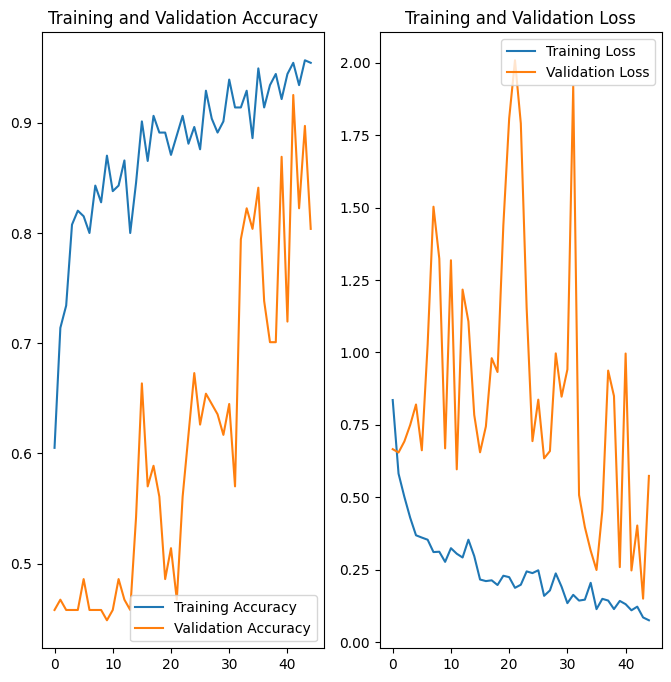

In [29]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()